# Set up 

In [1]:
SEED = 1
import random
random.seed(SEED)

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [3]:
Teusink_ant ='../../../models/Antimony/topologyB-noReg.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.7241056990445864e-15

In [4]:
pt_levels = [1.5]
pt_labels = ['1.5x']

In [5]:
metabolites = r.getFloatingSpeciesIds() + r.getBoundarySpeciesIds()
data = pd.read_csv('../../../data/generated_data/topologyB-noReg/topologyB-noReg_1.5.csv')

# Running ADVI

In [6]:
def run_BayesInf(BMCA_obj, n_samp=1):
    np.random.seed(SEED)
    random.seed(SEED)

    known_chi_inds = []
    omitted_chi_inds = []
    for i, sp in enumerate(r.getFloatingSpeciesIds()):
        if sp in BMCA_obj.xn.columns:
            known_chi_inds.append(i)
        else: 
            omitted_chi_inds.append(i)
    chi_inds = np.hstack([known_chi_inds, omitted_chi_inds]).argsort()

    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(r.getBoundarySpeciesIds()):
        if y in BMCA_obj.yn.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:
    
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        if omitted_chi_inds: 
            chi_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
            chi_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_chi_inds), len(BMCA_obj.xn)))
            chi_t = at.concatenate([chi_measured, chi_unmeasured], axis=0)[chi_inds, :]
            pm.Deterministic('chi_t', chi_t)
        else: 
            chi_t = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)

        if omitted_y_inds:
            y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.yn.T)
            y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=5, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))
            y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
            pm.Deterministic('y_t', y_t)
        else: 
            y_t = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)

        e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T) # e_hat?

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        N_ITERATIONS = 40000

        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace, random_seed=SEED)

    return trace, ppc_vi

No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 982.1
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 973.76
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,008.6
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 978.7
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 986.69
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,003.8
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 944.16
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 920.12
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 991.88
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 966.52
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,001.9
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 980.49
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,003
Sampling: [chi_measured, e_t, v_hat_obs, y_obs]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,463.3
Sampling: [chi_obs, e_t, v_hat_obs, y_measured]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,464.7
Sampling: [chi_obs, e_t, v_hat_obs, y_measured]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,463.9
Sampling: [chi_obs, e_t, v_hat_obs, y_measured]


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,463.5
Sampling: [chi_obs, e_t, v_hat_obs, y_measured]


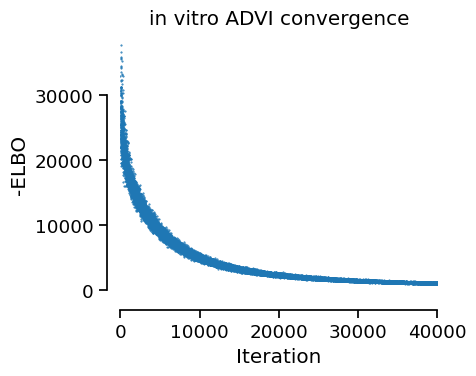

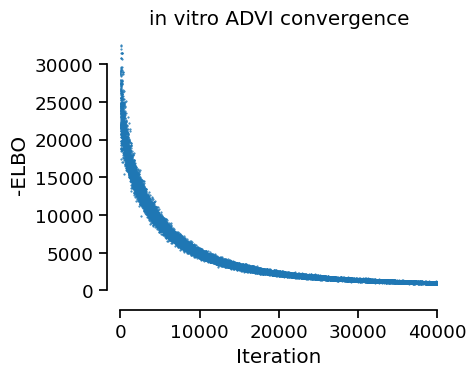

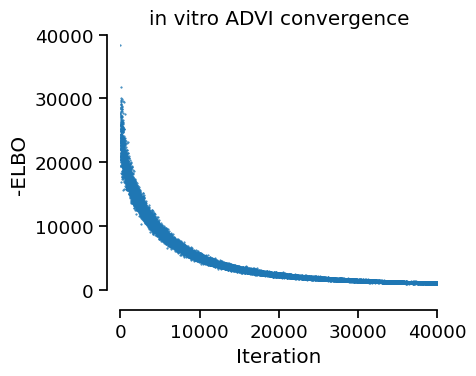

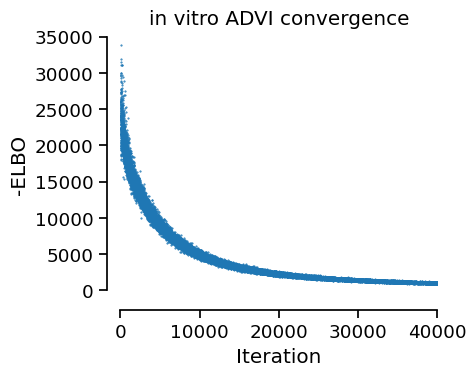

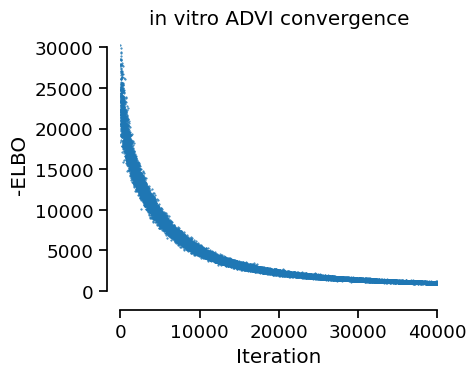

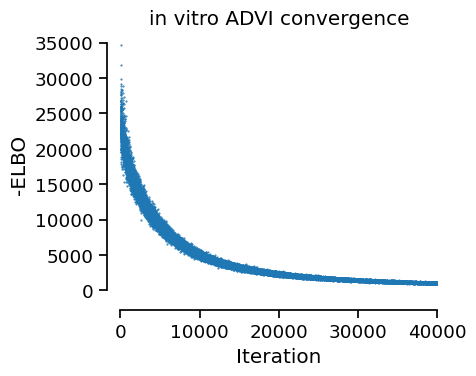

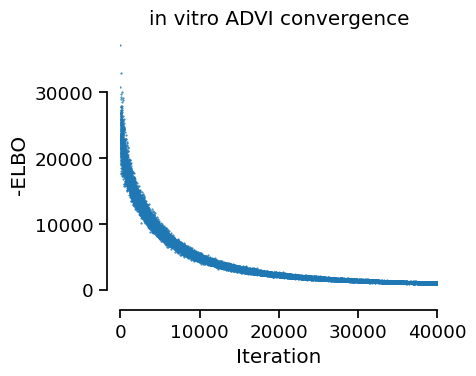

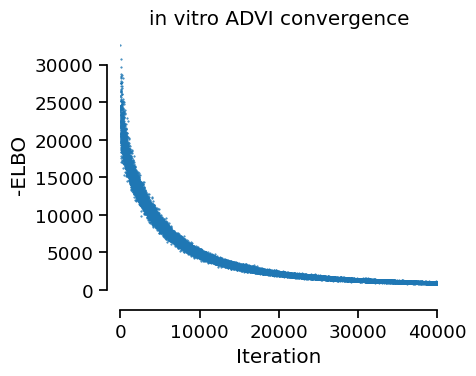

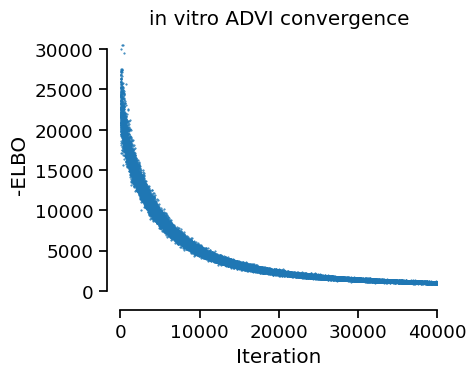

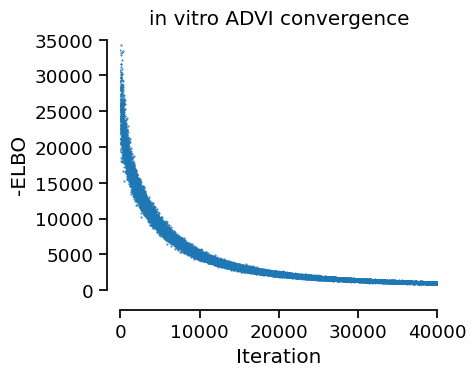

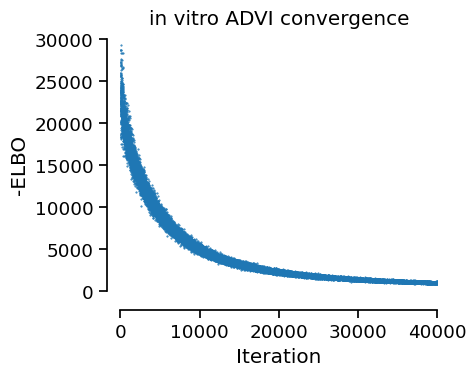

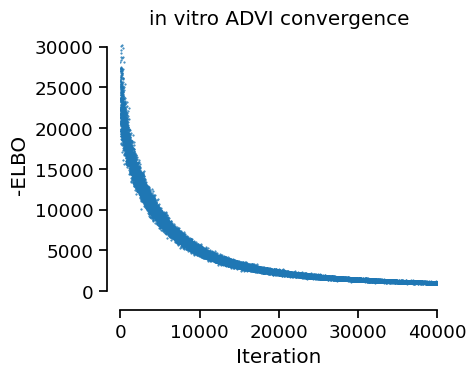

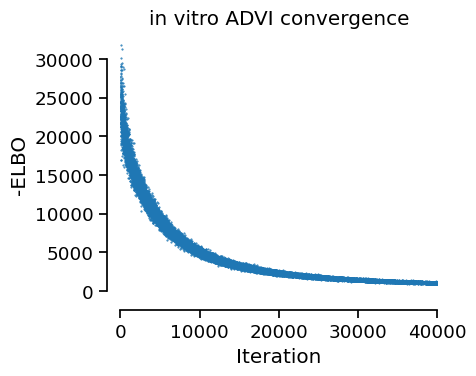

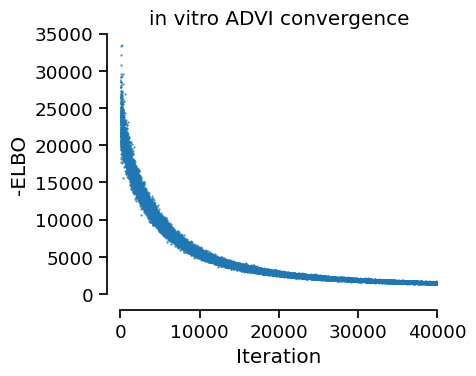

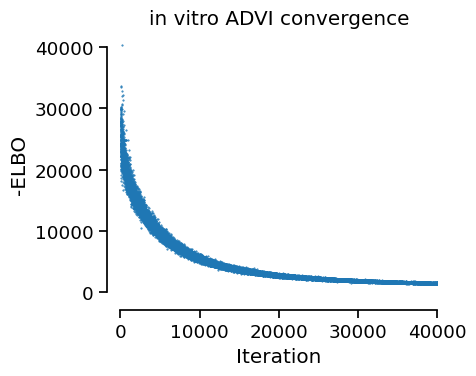

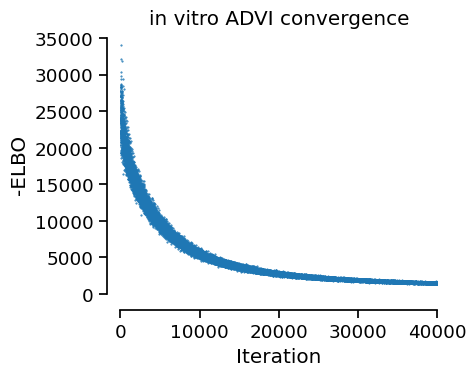

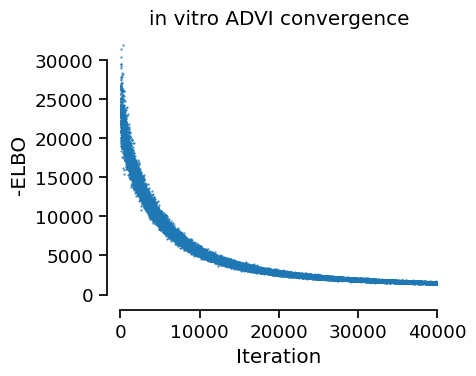

In [7]:
for m in metabolites: 
    data15 = data[data.columns.drop(m)]
    BMCA_obj15 = antemll.antemll(Teusink_ant, data15, '../../../models/sbml/topologyB_cobra.xml')
    trace15, ppc15 = run_BayesInf(BMCA_obj15)

    with gzip.open(f"../../../data/results/picklejar/giraffe-topB_{m}.pgz", "wb") as f:
            cloudpickle.dump(
                { 
                "trace15": trace15,
                "ppc15":ppc15,
                },
                f,
            )


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,740.7
Sampling: [chi_obs, e_t, v_hat_obs, y_obs]


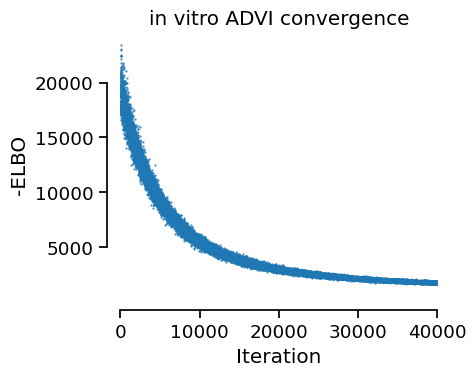

In [8]:
BMCA_obj15 = antemll.antemll(Teusink_ant, data, '../../../models/sbml/topologyB_cobra.xml')
trace15, ppc15 = run_BayesInf(BMCA_obj15)

with gzip.open(f"../../../data/results/picklejar/giraffe-topB_allMets.pgz", "wb") as f:
    cloudpickle.dump(
        { 
        "trace15":trace15,
        "ppc15":ppc15,
        },
        f,
    )

# Analysis

In [9]:
metSens_dict = dict()

for m in metabolites: 
    with gzip.open(f"../../../data/results/tracePickles/giraffe-topB_{m}.pgz", "rb") as f:
        traces = cloudpickle.load(f, encoding='bytes')

    metSens_dict[m] = (traces['trace15'], traces['ppc15'])

with gzip.open(f"../../../data/results/tracePickles/giraffe-topB_allMets.pgz", "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

metSens_dict['none'] = (traces['trace15'], traces['ppc15'])

### Elasticity check 

In [10]:
metSens_dict.keys()

dict_keys(['D', 'B', 'O', 'F', 'H', 'M', 'E', 'R', 'I', 'C', 'N', 'G', 'L', 'A', 'J', 'P', 'Q', 'none'])

In [11]:
Ex_dict = dict()

for i in metSens_dict.keys():
    Ex_dict[i] = util.get_az_summary(metSens_dict[i][0])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [12]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten()] + [Ex_dict[i] for i in Ex_dict.keys()])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+[i for i in Ex_dict.keys()], 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
elasticities_df.head()

,gt,D,B,O,F,H,M,E,R,I,C,N,G,L,A,J,P,Q,none
v1_D,0.000000,-0.004,-0.015,-0.005,0.000,0.005,0.003,-0.001,0.003,-0.004,-0.009,-0.004,0.001,0.014,0.000,0.002,0.007,-0.003,0.007
v1_B,-0.278258,-0.341,-0.150,-0.349,-0.346,-0.349,-0.350,-0.347,-0.338,-0.351,-0.346,-0.347,-0.335,-0.341,-0.341,-0.342,-0.334,-0.350,-0.340
v1_O,0.000000,-0.007,-0.005,-0.008,-0.005,-0.004,-0.001,-0.008,0.000,0.003,0.002,-0.002,-0.010,-0.003,-0.005,-0.002,0.000,0.003,0.004
v1_F,0.000000,-0.006,-0.011,-0.001,0.007,-0.001,0.005,0.003,0.003,0.001,-0.005,0.003,0.002,-0.008,-0.005,0.008,0.008,0.001,0.003
v1_H,0.000000,0.000,-0.007,-0.001,-0.007,0.002,-0.001,-0.001,0.007,0.000,-0.010,0.005,-0.007,0.003,-0.004,-0.002,0.000,0.000,-0.002


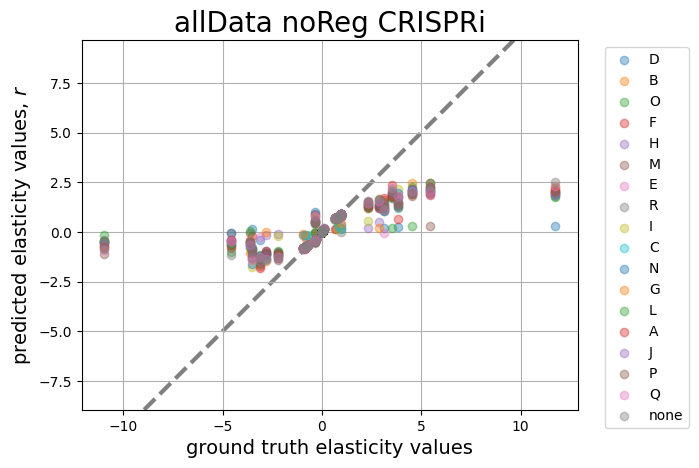

In [13]:
plt.axes().set_aspect('equal', 'datalim')

for i in Ex_dict.keys():
    plt.scatter(elasticities_df['gt'], elasticities_df[i], alpha=0.4, label=i, zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


In [14]:
RMSE = np.sqrt(((elasticities_df.sub(elasticities_df['gt'], axis=0))**2).mean())
RMSE

gt      0.000000
D       1.101075
B       1.029327
O       1.083565
F       1.055558
H       1.091380
M       1.099303
E       1.078656
R       1.068230
I       1.037098
C       1.071187
N       1.128692
G       1.079238
L       1.087003
A       1.051842
J       1.060104
P       1.028804
Q       1.021173
none    1.007237
dtype: float64

In [15]:
highlight_labels = {'A', 'J', 'P', 'Q'}
branch_labels = {'B', 'D', 'F', 'O'}

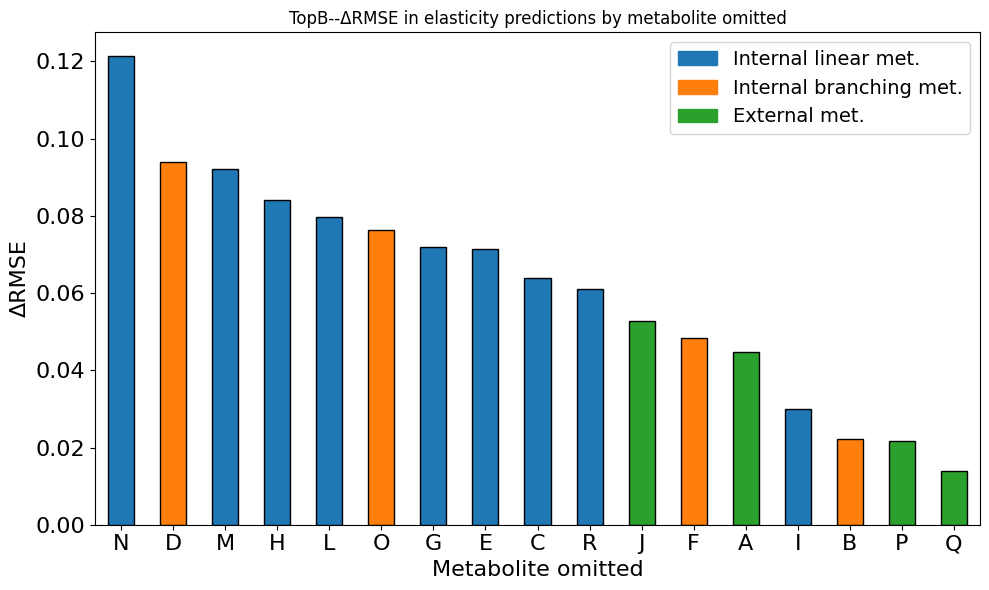

In [16]:
RMSE_sorted = RMSE.drop(['gt','none'], errors='ignore')  # Drop gt if it's in there
RMSE_sorted = RMSE_sorted.sort_values(ascending=False)

delta_RMSE_sorted = RMSE_sorted.sub(RMSE['none'])
# Build a list of colors, yellow if in highlight_labels, skyblue otherwise
bar_colors = [
    'tab:green' if label in highlight_labels
    else 'tab:orange' if label in branch_labels
    else 'tab:blue'
    for label in delta_RMSE_sorted.index
]
plt.figure(figsize=(10, 6))
delta_RMSE_sorted.plot(kind='bar', edgecolor='black', color=bar_colors) # , color='skyblue')

# plt.ylim(1,1.14)
plt.ylabel("ΔRMSE", fontsize=16)
plt.xlabel("Metabolite omitted", fontsize=16)
plt.title("TopB--ΔRMSE in elasticity predictions by metabolite omitted")
plt.xticks(rotation=0, ha='center', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()


# Create custom legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='tab:blue', label='Internal linear met.')
orange_patch = mpatches.Patch(color='tab:orange', label='Internal branching met.')
green_patch = mpatches.Patch(color='tab:green', label='External met.')
plt.legend(handles=[blue_patch, orange_patch, green_patch], fontsize=14)
plt.savefig('../../../visualize/raw_svg_figures/topologyB-giraffe.svg', format='svg')

In [17]:
r.getBoundarySpeciesIds()

['A', 'J', 'P', 'Q']